# Introduction
## Load Python Library

In [1]:
import numpy as nm
import cv2
import matplotlib.pyplot as plt
import imageio
imageio.plugins.ffmpeg.download()

from moviepy.editor import VideoFileClip

from IPython.display import HTML

# 2.Function Description
## 2.1. Color Select Function

In [2]:
def colorSelect(image):
    white_th  = [200,200,200]
    orange_th = [230, 130, 10]
    
    color_select = nm.copy(image)
    rgb_threshold = (image[:,:,0] < white_th[0]) | (image[:,:,1] < white_th[1]) | (image[:,:,2] < white_th[2]) 

    orange_threshold = (image[:,:,0] < orange_th[0]) | (image[:,:,1] < orange_th[1]) | (image[:,:,2] < orange_th[2])
    
    color_select[rgb_threshold&orange_threshold] = [0,0,0]  
    
    return color_select

## 2.2 Masking Valid Region Fucntion

In [3]:
def regionMask(image):
    region_select = nm.copy(image)
    
    left_bottom = [0,image.shape[0]]
    right_bottom = [image.shape[1], image.shape[0]]
    apex = [image.shape[1]/2, image.shape[0]/2]
    
    xsize = image.shape[1]
    ysize = image.shape[0]
    
    
    # Perform a linear fit (y=Ax+B) to each of the three sides of the triangle
    # np.polyfit returns the coefficients [A, B] of the fit
    fit_left = nm.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
    fit_right = nm.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
    fit_bottom = nm.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

    # Find the region inside the lines
    XX, YY = nm.meshgrid(nm.arange(0, xsize), nm.arange(0, ysize))
    region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                        (YY > (XX*fit_right[0] + fit_right[1])) & \
                        (YY < (XX*fit_bottom[0] + fit_bottom[1]))

    region_select[~region_thresholds] = [0,0,0] 
   # region_select[region_thresholds] = [255,255,255] 
    
    return region_select 

## 2.3 Edge Detection Function with Canny Filter 

In [4]:
def cannyFilter(image):
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    # Define a kernel size for Gaussian smoothing / blurring
    kernel_size = 3 # Must be an odd number (3, 5, 7...)
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    # Define our parameters for Canny and run it
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
        
    return edges
    

## 2.4 Hogh Line Detect Function with Porbability

In [5]:
def hough(image):
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = nm.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40 #minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments
    
    #img_gs = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    line_image = nm.copy(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB))*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(image, rho, theta, threshold, nm.array([]), min_line_length, max_line_gap)

    if lines is None:
            return line_image
    
    for line in lines:
        x1,y1,x2,y2 = line[0]
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
    
    
    return line_image

# 3. Load Lane-Line Image Detection Pipeline 

In [6]:
def detectLine(image):
    region_img = regionMask(image)
    color_img = colorSelect(region_img)
    canny_img = cannyFilter(color_img)
    lines =  hough(canny_img)
    
    result = cv2.addWeighted(lines, 0.8, image, 1, 0) 
    
    return result

# 4. Each Function Testing
## 4.1. Image Load Test

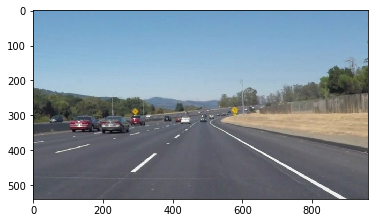

In [7]:
im = cv2.imread('./test.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

## 4.2. Color Select Test

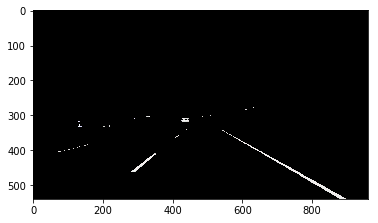

In [8]:
img = cv2.imread('./test.jpg')
img = colorSelect(img)
plt.imshow(img)

## 4.3. Detect Reagion Test

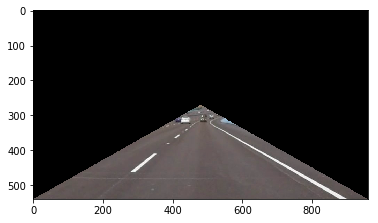

In [9]:
img = cv2.imread('./test.jpg')
img = regionMask(img)
plt.imshow(img)

## 4.4. Edge Detect Test with Canny Fileter

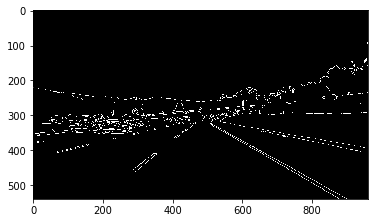

In [10]:
img = cv2.imread('./test.jpg')
img = cannyFilter(img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB))

# 5. PipeLine Processing Test from Image Source

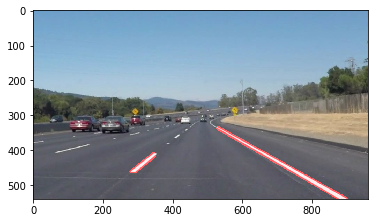

In [11]:
img = cv2.imread('./test.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

hough_img = detectLine(img)

plt.imshow(hough_img)

# 6. PipeLine Processing Test from Movie Data Source
## 6.1. Load Target Movie File Source

In [12]:
HTML("""
<video width="640" height="480" controls>
    <source src="test.mp4" type="video/mp4">
</video>    
""")

## 6.2. Conversion Lane-line Detected movie

In [13]:
new_clip_output = 'test_output.mp4'
test_clip = VideoFileClip("test.mp4")
new_clip = test_clip.fl_image(lambda x: detectLine(x))
#new_clip = test_clip.fl_image(lambda x: x)

%time new_clip.write_videofile(new_clip_output, audio=False)

[MoviePy] >>>> Building video test_output.mp4
[MoviePy] Writing video test_output.mp4


100%|██████████| 251/251 [00:18<00:00, 13.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output.mp4 

CPU times: user 17.6 s, sys: 4.06 s, total: 21.7 s
Wall time: 19 s


## 6.3. Result Movie

In [14]:
HTML("""
<video width="640" height="480" controls>
    <source src="test_output.mp4" type="video/mp4">}
</video>    
""")